# Merging classification results

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import evaluate
import merge
import load

In [2]:
# Load evaluation data
test_columns = ['returnQuantity', 'articleID', 'productGroup', 'customerID', 'voucherID']
test_predictions = merge.merged_predictions(test=True, keep_columns=test_columns)
test_train = evaluate.test_complement(test_predictions)

# Load classification data
class_columns = ['articleID', 'productGroup', 'customerID', 'voucherID']
class_predictions = merge.merged_predictions(keep_columns=class_columns)
class_train = load.orders_train()

## Confidences
### Imputation

Approximately 4% of predictions by team C have unknown confidences, making imputation necessary before merge approaches based on confidence can be applied. Because of this relatively small number, I propose to impute missing values using the mean confidence of Team C. The mean showed stable behavior across all splits in the test and prediction data.

### Comparison
Using approaches based on confidence implies comparison across classifiers. This is complicated by the different distributions of confidence, as depicted in the figure below.

In [3]:
# Violinplot for class data and evaluation data
def confidence_plot(class_data, evaluation_data):  
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    ax1.set_title('Classification')
    ax = sns.violinplot(data=class_data['confidence'], ax=ax1)
    ax2.set_title('Evaluation')
    ax = sns.violinplot(data=evaluation_data['confidence'], ax=ax2)

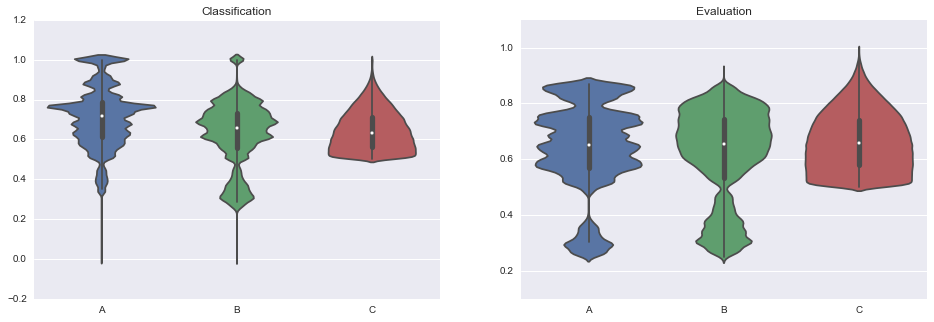

In [4]:
# Violinplot for original data
confidence_plot(class_predictions, test_predictions)

Instead of using the actual values, I propose to redefine each classifier's confidences as distance from its mean confidence. The confidence distribution's center is then moved to 1.

The ca. 3% missing confidence values are imputed with the mean.

The figure below shows the distributions of the imputed predictions.

In [5]:
# Impute zeroes and convert confidenes to std-distances
test_imputed = merge.impute_confidence(test_predictions)
class_imputed = merge.impute_confidence(class_predictions)

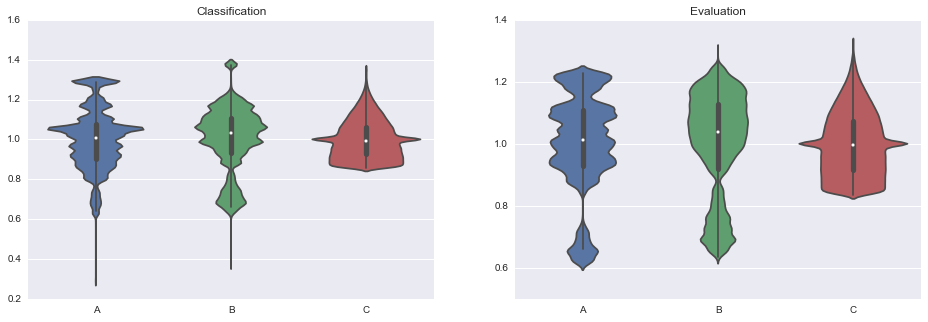

In [6]:
# Violinplot for imputed data
confidence_plot(class_imputed, test_imputed)

## Approach 1: Naive Majority Vote
For each row, take the most common prediction. As we have 3 teams there is always a majority.

The naive majority vote assumes that each classifier is equally good and always equally confident. It uses relies on the least assumptions about performance evaluation and confidence comparability.

In [7]:
test_naive = merge.naive_majority_vote(test_predictions)
class_naive = merge.naive_majority_vote(class_predictions)

This approach can be evaluated on the test set; the result is shown in the figure below.

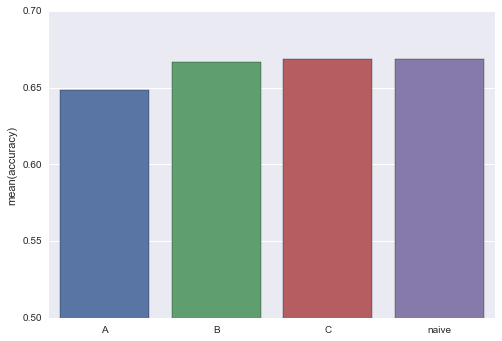

In [8]:
# Calculate mean accuracies
naive_accuracies = evaluate.mean_accuracies(test_naive)

# Barplot
ax = sns.barplot(x=naive_accuracies.index, y=naive_accuracies['accuracy'])
lim = ax.set_ylim([0.5, 0.7])

The values are 64.85%, 66.66%, 66.86% and 66.89% in that order. The approach seems to yield a very small improvement compared to the best performing single team classification.

However, the new classification seems to resolve most of the arguments between the teams (cf. figure below). The naive merge seems to agree with teams A and C (under 1% distinct rows), while disagreeing mostly with team B (11%).

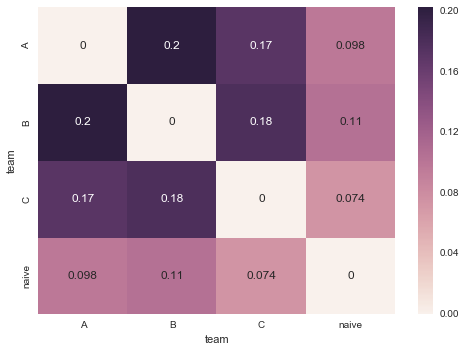

In [9]:
# Calculate difference for each combination
naive_differences = evaluate.distinct_predictions(class_naive)

# Heatmap
ax = sns.heatmap(naive_differences, annot=True)

The differences between the naive merge and team B go along with the differences team B had with other teams, the top four splits not present in the test set.

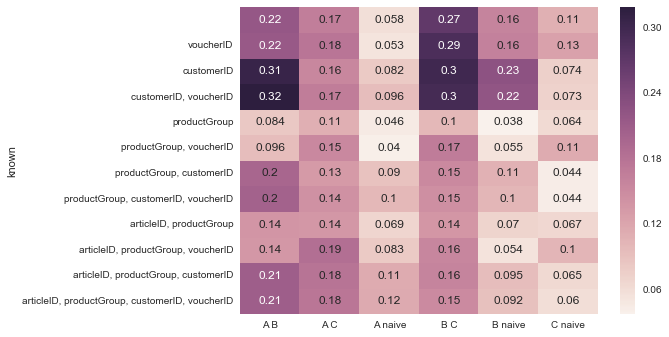

In [10]:
# Calculate differences across splits
naive_split_differences = evaluate.distinct_split_predictions(class_train, class_naive)

# Heatmap
ax = sns.heatmap(naive_split_differences, annot=True)

## Approach 2: Weighted Majority Vote
There are multiple ways to combined confidences, accuracies and own values into weights. Some of them are evaluated here.

### Confidence only
TODO

In [11]:
# Equal weight for each classifier
equal_weights = pd.Series([1,1,1], index=['A', 'B', 'C'])

# Calculate majority vote for test and classification data
test_weighted_confidence = merge.weighted_majority_vote(test_imputed, equal_weights)
class_weighted_confidence = merge.weighted_majority_vote(class_imputed, equal_weights)

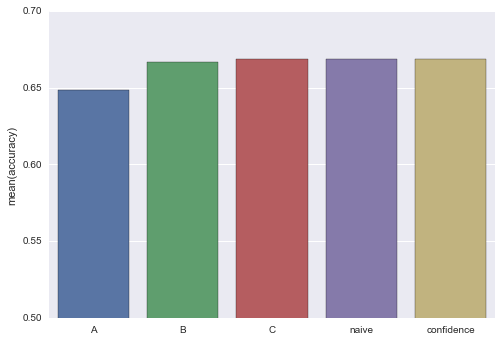

In [12]:
merged = test_naive.copy()
merged['prediction', 'confidence'] = test_weighted_confidence['prediction']['weighted']

# Calculate mean accuracies
mean_accuracies = evaluate.mean_accuracies(merged)

# Barplot
ax = sns.barplot(x=mean_accuracies.index, y=mean_accuracies['accuracy'])
lim = ax.set_ylim([0.5, 0.7])

TODO
### Accuracy with equal confidence
TODO

In [13]:
equal_confidence = test_imputed.copy()
equal_confidence['confidence'] = 1

# Evaluate mean accuracies for each classifier
mean_accuracies = evaluate.mean_accuracies(test_predictions)['accuracy']
accuracy_weights = np.power(mean_accuracies / mean_accuracies.mean(), 3)

# Calculate majority vote for test and classification data
test_weighted_accuracy = merge.weighted_majority_vote(equal_confidence, accuracy_weights)
class_weighted_confidence = merge.weighted_majority_vote(equal_confidence, accuracy_weights)

In [14]:
evaluate.mean_accuracies(test_weighted_accuracy)

,accuracy
A,0.648500
B,0.666572
C,0.668590
weighted,0.668855


In [31]:
# Evaluate mean accuracies for each classifier
mean_accuracies = evaluate.mean_accuracies(test_predictions)['accuracy']
accuracy_weights = np.power(mean_accuracies / mean_accuracies.mean(), 61)

applied_confidences = test_imputed.copy()
applied_confidences['confidence'] = applied_confidences['confidence'].applymap(lambda d: np.power(d, 1))

test_weighted_accuracy = merge.weighted_majority_vote(applied_confidences, accuracy_weights)
evaluate.mean_accuracies(test_weighted_accuracy)
# 9112
# 9257
# 9375
# 9645
# 0001
# 0526
# 0559

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-ca5fabf0d052>", line 8, in <module>
    test_weighted_accuracy = merge.weighted_majority_vote(applied_confidences, accuracy_weights)
  File "/Users/williraschkowski/dev/dmc-results/merge.py", line 67, in weighted_majority_vote
    pool = mp.Pool()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/context.py", line 118, in Pool
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/pool.py", line 150, in __init__
    self._setup_queues()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/pool.py", line 243, in _setup_queues
    self._inqueue = self._ctx.SimpleQueue()
  File "/Library/Frameworks/Python.framework/Versions/3.5/li

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



OSError: [Errno 24] Too many open files

In [25]:
accuracy_weights

A    0.305747
B    1.635136
C    1.966170
Name: accuracy, dtype: float64

## Approach 3: Avoiding disagreement

In [16]:
### Approach 4: Weighted Majority Vote based on plits